In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"  # Disable multithreading to avoid memory leak



In [2]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Evaluation
from sklearn.metrics import silhouette_score


In [3]:
# Loading the data
df = pd.read_csv(r"C:\Users\Admin\Documents\GitHub\Mall_Customers_Segmentation\Mall_Customers_Segmentation\Mall_Customers.csv")
df.head

<bound method NDFrame.head of      CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)
0             1    Male   19                  15                      39
1             2    Male   21                  15                      81
2             3  Female   20                  16                       6
3             4  Female   23                  16                      77
4             5  Female   31                  17                      40
..          ...     ...  ...                 ...                     ...
195         196  Female   35                 120                      79
196         197  Female   45                 126                      28
197         198    Male   32                 126                      74
198         199    Male   32                 137                      18
199         200    Male   30                 137                      83

[200 rows x 5 columns]>

In [4]:
# Checking for missing values
df.isnull().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [12]:
# Checking for duplicates
df.duplicated().sum()

0

In [18]:
#Checking datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [17]:
# Basic statistics of the dataset
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


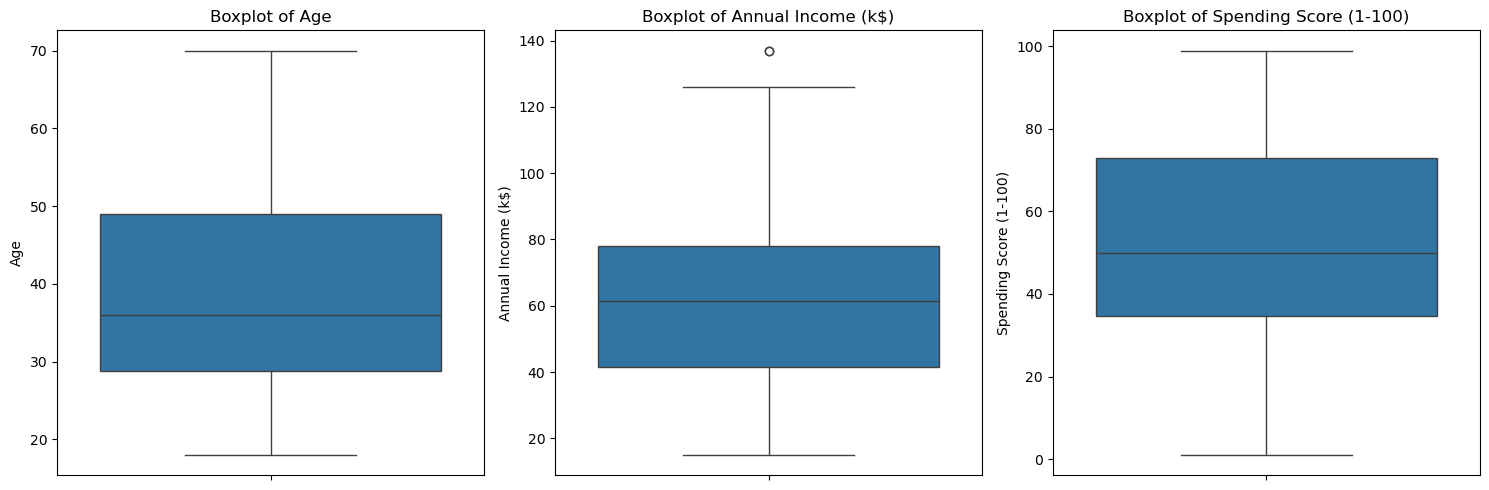

In [7]:
# Set up the layout
plt.figure(figsize=(15, 5))

features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Loop through numerical features
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()


One mild outlier was observed in the Annual Income feature, but it was retained as it does not significantly distort the scale.

In [9]:
# Select only the numerical features for clustering
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the data
scaled_data = scaler.fit_transform(df[features])

# Convert back to DataFrame for readability
scaled_df = pd.DataFrame(scaled_data, columns=features)

# Show the scaled data
scaled_df.head()


,Age,Annual Income (k$),Spending Score (1-100)
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


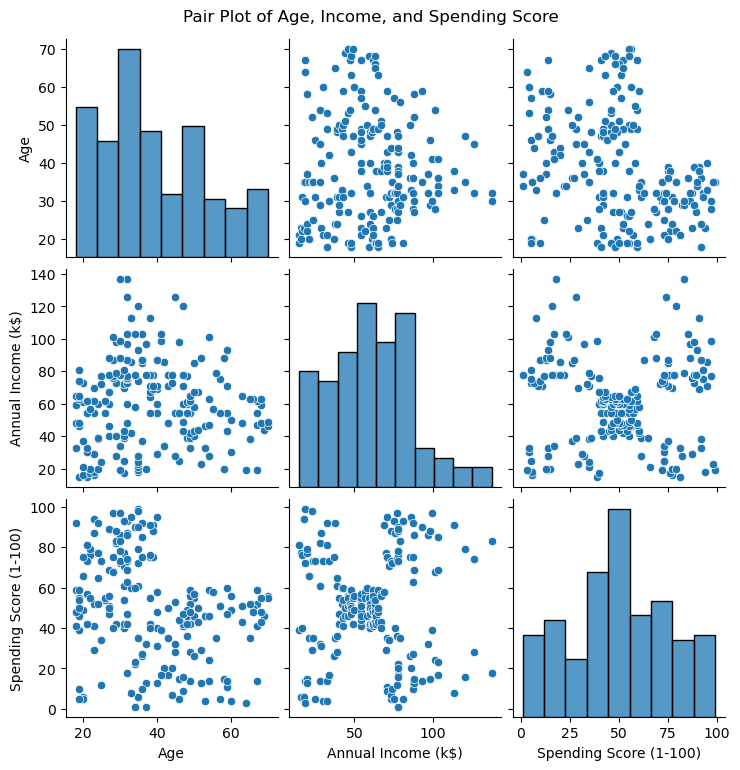

In [10]:
# Creating pair plot of the original numerical features
sns.pairplot(df[features])
plt.suptitle("Pair Plot of Age, Income, and Spending Score", y=1.02)
plt.show()

Interpretation:
The pair plot visualizes relationships between Age, Annual Income, and Spending Score:
1. Age vs. Annual Income:
   - Likely a weak or nonlinear correlation. Younger and older customers may have lower incomes, while middle-aged customers show variability.

2. Age vs. Spending Score:
   - Potential negative trend: Younger customers might have higher spending scores, while older customers spend less. However, the bimodal distribution of spending scores complicates this.

3. Annual Income vs. Spending Score:
   - Possible clusters or segments (e.g., high-income moderate spenders vs. middle-income high spenders). This suggests that income alone doesn’t dictate spending behavior.

Key Insight: The lack of strong linear relationships highlights the need for segmentation (e.g., clustering analysis) to tailor strategies for distinct customer profiles (e.g., "High-Income Conservatives" vs. "Middle-Income Big Spenders").

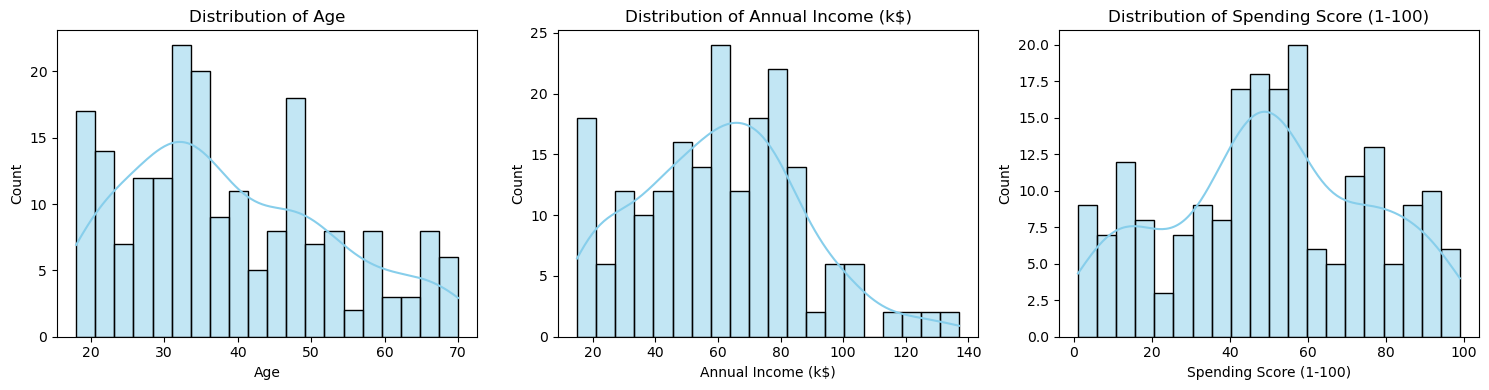

In [12]:
# Set figure size
plt.figure(figsize=(15, 4))

# Plot a histogram for each feature
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], kde=True, bins=20, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

**Interpretation:** The histograms illustrate the distribution of each variable individually:
1. Distribution of Age
    - Shape: The distribution appears to be slightly right-skewed, with a peak around the 30-40 age range.
    - Central Tendency: Most customers are between 30 and 50 years old, with fewer customers in the younger (20-30) and older (60-70) age groups.
    - Indicates: The mall's primary customer base is middle-aged, suggesting that marketing strategies could target this demographic more effectively.

2. Distribution of Annual Income (k$)
    - Shape: The distribution is roughly normal with a slight right skew, peaking around 65k and 75k.
    - Central Tendency: The majority of customers earn between 45k and 80k annually, with fewer individuals at the extremes (<20k or >120k).
    - Indicates: The mall caters predominantly to middle-income earners. Luxury brands or budget-friendly options may need tailored strategies to attract higher or lower-income segments.

3. Distribution of Spending Score (1-100)
    - Shape: The distribution is bimodal, with peaks around 40-60.
    - Central Tendency: Customers cluster into two groups—moderate spenders and high spenders. Few customers have very low or very high scores.
    - Indicates: The mall may have distinct customer segments (e.g., casual shoppers vs. enthusiastic spenders). Personalized promotions could enhance engagement for each group.



###  K-Means Clustering

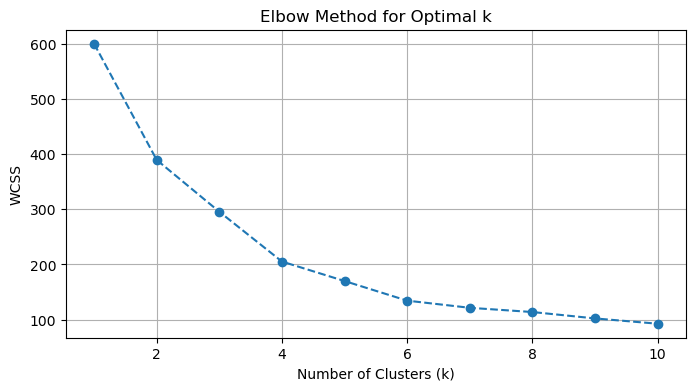

In [19]:
# Elbow Method to find optimal k
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)  # WCSS = Within-Cluster Sum of Squares

# Plot Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker="o", linestyle="--")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal k")
plt.grid()
plt.show()


    - The biggest drops in WCSS are between k = 1 and k = 3

    - After k = 5, the decrease becomes much more gradual

 Optimal k = 5 is the best choice - it’s the point where adding more clusters starts to yield diminishing returns in reducing WCSS. At this point, the WCSS shows a significant reduction compared to previous values, but further increases in k beyond 5 result in minimal improvement. This suggests that the customer data can be effectively grouped into five distinct segments.

In [20]:
# Fit K-Means with optimal k 
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_df)

# Add cluster labels to the original data
df["Cluster"] = clusters
print(df.head())

   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   

   Cluster  
0        2  
1        2  
2        3  
3        2  
4        2  


In [22]:
# Get cluster characteristics
df.groupby('Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean()


,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,
0,55.275862,47.620690,41.706897
1,32.875000,86.100000,81.525000
2,25.769231,26.115385,74.846154
3,26.733333,54.311111,40.911111
4,44.387097,89.774194,18.483871


### Interpretation:

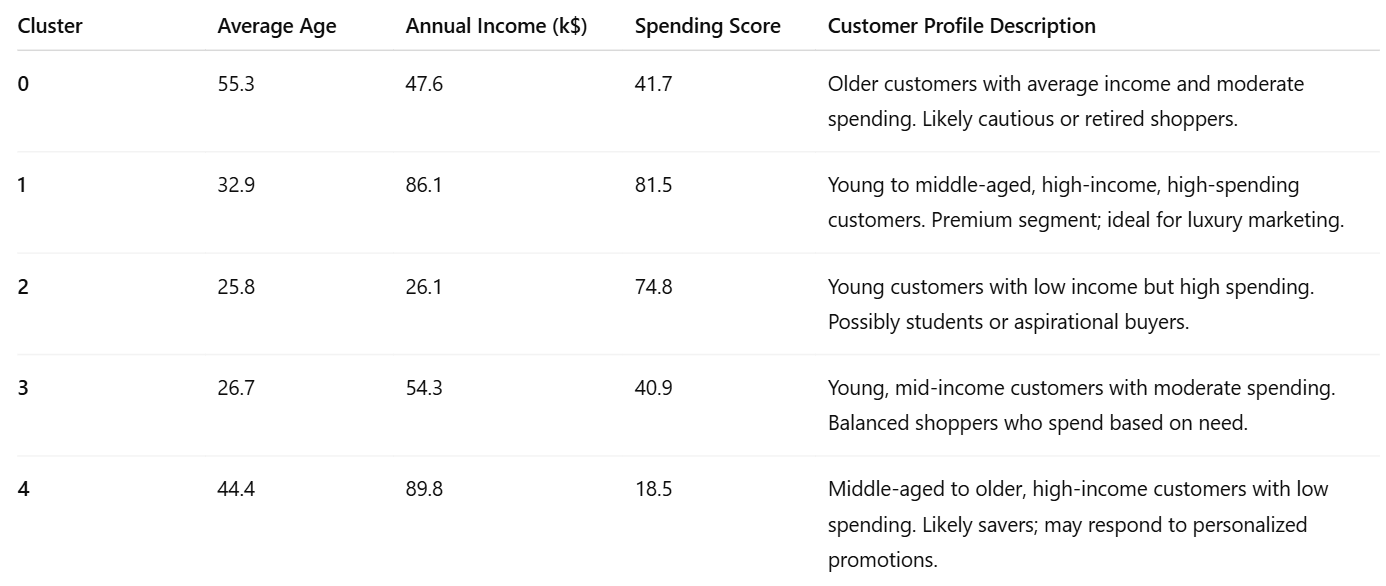

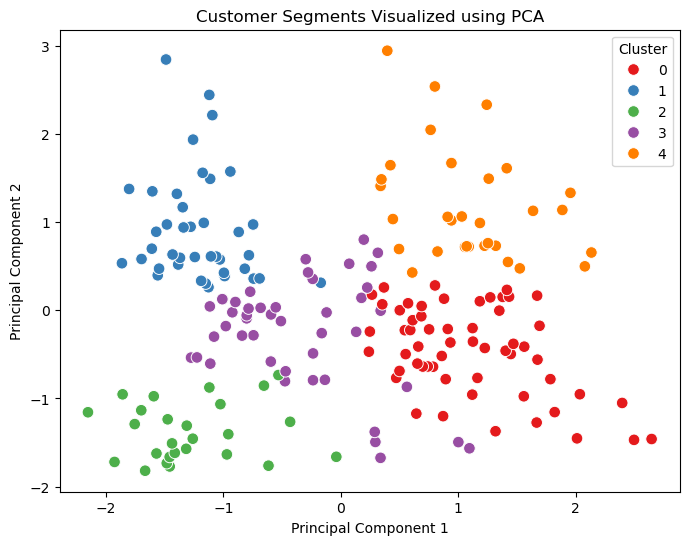

In [24]:
# Reduce to 2D for plotting
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_df)

# Create DataFrame for plotting
pca_df = pd.DataFrame(data=pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = clusters

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', s=70)
plt.title('Customer Segments Visualized using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

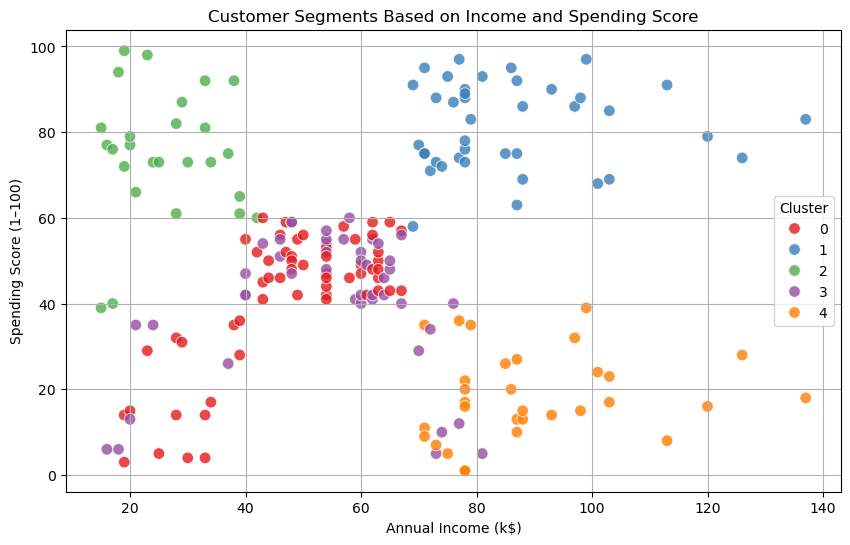

In [26]:
# Scatter plot using original features
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df, 
    x='Annual Income (k$)', 
    y='Spending Score (1-100)', 
    hue='Cluster', 
    palette='Set1', 
    s=70, 
    alpha=0.8
)
plt.title("Customer Segments Based on Income and Spending Score")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1–100)")
plt.legend(title='Cluster')
plt.grid(True)
plt.show()